In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl
import copy
import sys

from matplotlib import patches

import larch.io as lio
import larch.xafs as lx

from larch import Group
from larch.fitting import param, guess, param_group

from sp8 import *

In [81]:
sys.setrecursionlimit(10000)

In [66]:
group = lio.read_ascii('es/cu.dat', labels='energy mu')

In [67]:
e0_ref = 8980.3
mask = (group.energy > e0_ref - 10) & (group.energy < e0_ref + 10)
lx.find_e0(
    group.energy[mask],
    group.mu[mask],
    group=group
)
e0_shift = e0_ref - group.e0
print(e0_shift)

8982.40000000019

-2.1000000001913577


(8930.3, 9080.3)

(-0.1, 1.1)

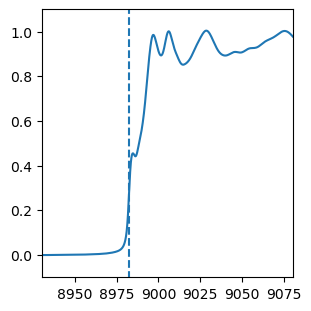

In [68]:
lx.pre_edge(
    group,
    pre1=-200,
    pre2=-30,
    norm1=150,
    nvict=2,
    nnorm=3
)

fig, ax = plt.subplots(layout='constrained')
ax.plot(group.energy, group.norm)
ax.vlines(group.e0, -999, 999, linestyles='--')
ax.set_xlim(e0_ref-50, e0_ref+100)
ax.set_ylim(-0.1, 1.1)
fig.set_size_inches(3, 3)

In [69]:
group.energy += e0_shift
group.e0 += e0_shift

In [72]:
autobk_kwargs = {
    'e0': e0_ref,
    'kmin': 0,
    'kmax': 20,
    'rbkg': 1,
    'kweight': 2,
    'win': 'Hanning',
    'dk': 4,
    'clamp_lo': 1,
    'clamp_hi': 1000
}
xftf_kwargs = {
    'kmin': 2.5,
    'kmax': 19.5,
    'dk': 4,
    'kweight': 3,
    'window': 'hanning'
}

lx.autobk(group.energy, group.norm, group=group, **autobk_kwargs)
lx.xftf(group.k, group.chi, group=group, **xftf_kwargs)

(8930.3, 9130.3)

(0.0, 8.0)

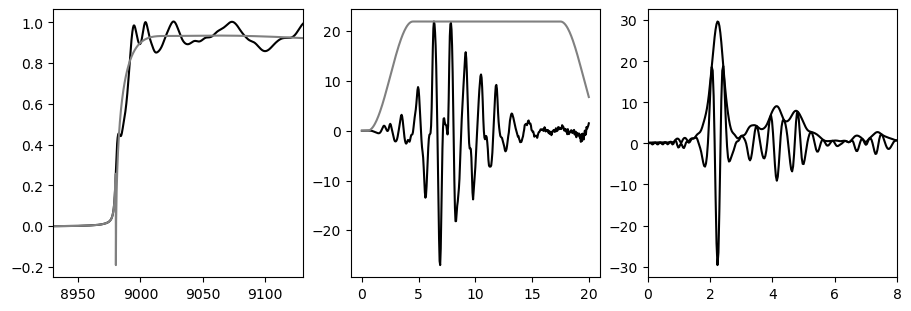

In [88]:
fig, axs = plt.subplots(nrows=1, ncols=3, layout='constrained')
axs[0].plot(group.energy, group.norm, color='k')
axs[0].plot(group.energy, group.bkg, color='gray')
axs[0].set_xlim(group.e0-50, group.e0+150)
axs[1].plot(group.k, group.k**3*group.chi, color='k')
axs[1].plot(group.k, group.kwin*max(group.k**3*group.chi), color='gray')
axs[2].plot(group.r, group.chir_re, color='k')
axs[2].plot(group.r, group.chir_mag, color='k')
axs[2].set_xlim(0, 8)
fig.set_size_inches(9, 3)

In [99]:
pars = param_group(
    s02     = param(0.8, vary=True, min=0.0, max=1.1),
    de0     = param(0.0, vary=True, min=-20.0, max=20.0),
    alpha   = param(0, vary=True, min=-2, max=2),
    # dr1     = param(0, vary=True, min=-0.5, max=0.5),
    sig1    = param(0.005, vary=True, min=0.0001, max=0.05),
    n1      = param(1, vary=False),
    # dr2     = param(0, vary=True, min=-0.5, max=0.5),
    sig2    = param(0.005, vary=True, min=0.0001, max=0.05),
    n2      = param(1, vary=False),    
    # dr3     = param(0, vary=True, min=-0.5, max=0.5),
    sig3    = param(0.005, vary=True, min=0.0001, max=0.05),
    n3      = param(1, vary=False)
    )

p1 = lx.feffpath(
    'feff-std/Cu_Cu_2.5562.f8',
    s02='s02*n1',
    e0='de0',
    deltar='alpha*reff',
    # deltar='dr1',
    sigma2='sig1'
)
p2 = lx.feffpath(
    'feff-std/Cu_Cu_3.6150.f8',
    s02='s02*n2',
    e0='de0',
    deltar='alpha*reff',
    # deltar='dr2',
    sigma2='sig2'
)
p3 = lx.feffpath(
    'feff-std/Cu_Cu_4.4274.f8',
    s02='s02*n3',
    e0='de0',
    deltar='alpha*reff',
    # deltar='dr3',
    sigma2='sig3'
)

trans = lx.feffit_transform(rmin=1, rmax=3, **xftf_kwargs)
dset = lx.feffit_dataset(data=group, pathlist=[p1, p2, p3], transform=trans)

In [100]:
out = lx.feffit(pars, [dset], max_nfev=3000)
print(lx.feffit_report(out))

=================== FEFFIT RESULTS ====================
[[Statistics]]
  n_function_calls     = 194
  n_variables          = 6
  n_data_points        = 130
  n_independent        = 22.6450723
  chi_square           = 2.71096495
  reduced chi_square   = 0.16286892
  r-factor             = 0.00202661
  Akaike info crit     = -36.0672824
  Bayesian info crit   = -29.3476288
 
[[Parameters]]
  alpha                = -0.0067142 +/- 6.4391e-4  (init= 0.0000000)
  de0                  =  4.7023905 +/- 0.3384222  (init= 0.0000000)
  n1                   =  1.0000000 (fixed)
  n2                   =  1.0000000 (fixed)
  n3                   =  1.0000000 (fixed)
  s02                  =  0.9171564 +/- 0.0245655  (init= 0.8000000)
  sig1                 =  0.0088873 +/- 1.8102e-4  (init= 0.0050000)
  sig2                 =  0.0214252 +/- 0.0095917  (init= 0.0050000)
  sig3                 =  0.0500000 +/- 0.0645108  (init= 0.0050000)
 
[[Correlations]] (unreported correlations are <  0.100)
  s02